# UK Housing Price Prediction - First simple model

**Author:** Jo Naulaerts

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load the Feature-Engineered Data

In [ ]:
df = pd.read_parquet('../Data/housing_features_final.parquet')

In [6]:
print(df.columns)

Index(['transaction_unique_identifier', 'price', 'date_of_transfer', 'year',
       'month', 'quarter', 'year_month', 'base_rate', 'mortgage_2yr',
       'mortgage_10yr', 'exchange_rate_index', 'log_price', 'property_F',
       'property_O', 'property_S', 'property_T', 'is_new_build', 'day_of_week',
       'is_weekend', 'is_spring', 'is_summer', 'is_autumn', 'is_winter',
       'month_sin', 'month_cos', 'years_since_2008', 'is_crisis_period',
       'is_recovery_period', 'mortgage_spread_10_2', 'mortgage_spread_5_2',
       'base_rate_change', 'mortgage_5yr_change', 'exchange_rate_index_change',
       'district_encoded', 'county_encoded'],
      dtype='object')


## 3. Prepare Data for Modeling

This code prepares a dataset for modeling by separating the target variable and the input features. It first defines the target column (log_price), then removes that and a few other unnecessary columns from the feature set. Finally, it creates X containing all predictor variables and y containing the target values to be used for training or evaluating a model.

In [ ]:
# Define the target and build drop_cols using available column names
target = 'log_price'
drop_cols = [col for col in ['log_price', 'price', 'date_of_transfer', 'transaction_unique_identifier'] if col in df.columns]

# Gather feature columns by excluding drop_cols
features = [col for col in df.columns if col not in drop_cols]

X = df[features]
y = df[target]

## 4. Train/Test Split (Temporal, not random)
This code splits the dataset into training and testing sets based on time rather than random sampling. It first sorts the data chronologically by date_of_transfer, then takes the first 80 percent as the training data and the remaining 20 percent as the test data, preserving the time order for a realistic time series evaluation.

In [ ]:
# Sort by date, 80% train, 20% test - for time series "honesty"
df = df.sort_values(by='date_of_transfer')
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

## 5. Fit a Simple Model

This code trains a Ridge Regression model using only the numeric and boolean features from the dataset. It splits the data into training and testing sets (as done earlier), fits the model on the training data, and then generates predictions for both the training and test sets to evaluate the model’s performance.

In [ ]:
import numpy as np
import pandas as pd

# Only use numeric (float/int/bool) columns for modeling
X_numeric = X.select_dtypes(include=[np.number, 'bool'])

# Train/test split (as before)
X_train, X_test = X_numeric.iloc[:split_idx], X_numeric.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Now fit your model
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

## 6. Inverse log transformation for price
This code performs an inverse log transformation on predicted and actual values to convert them back from the logarithmic scale to the original price scale. Since the model predicted the logarithm of prices (log_price), taking the exponential (np.exp) of these predictions and actual values recovers the estimated and true house prices in their original units. This step is essential for interpreting and evaluating the model's price predictions in meaningful terms rather than in the log scale.

In [ ]:
y_pred_price = np.exp(y_pred)
y_test_price = np.exp(y_test)
y_train_pred_price = np.exp(y_train_pred)
y_train_price = np.exp(y_train)

## 7. Evaluation Metrics
This code defines a function to print key evaluation metrics for regression model predictions both on the original logarithmic scale and the transformed price scale. It computes and prints the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²) on the log scale to assess model fit, along with MAE and Mean Absolute Percentage Error (MAPE) in the original price units (£) for real-world interpretability. The function is then called to display these metrics separately for the training and test datasets, helping to evaluate the model’s accuracy and predictive performance both in terms of transformed and original prices.

The log scale metrics quantify how well the model fits the transformed target, while the price scale metrics provide an interpretable error measure in currency units and percentage terms, which are more meaningful for stakeholders comparing predicted and actual prices.

In [ ]:
def print_metrics(actual, pred, actual_price, pred_price, label="Test"):
    print(f"\n{label} Set:")
    print(f"  RMSE (log): {np.sqrt(mean_squared_error(actual, pred)):.4f}")
    print(f"  MAE   (log): {mean_absolute_error(actual, pred):.4f}")
    print(f"  R2    (log): {r2_score(actual, pred):.3f}")
    print(f"  MAE   (£):   {mean_absolute_error(actual_price, pred_price):,.0f}")
    print(f"  MAPE  (£):   {np.mean(np.abs(actual_price - pred_price) / actual_price) * 100:.3f}%")

print_metrics(y_train, y_train_pred, y_train_price, y_train_pred_price, label="Train")
print_metrics(y_test, y_pred, y_test_price, y_pred_price, label="Test")


Train Set:
  RMSE (log): 0.5540
  MAE   (log): 0.4166
  R2    (log): 0.186
  MAE   (£):   95,165
  MAPE  (£):   45.362%

Test Set:
  RMSE (log): 0.6599
  MAE   (log): 0.4992
  R2    (log): 0.119
  MAE   (£):   137,510
  MAPE  (£):   57.902%


## 8. Visual Diagnostics
This code creates a figure with two side-by-side scatter plots to visually compare true versus predicted values from a regression model. The first plot shows true and predicted house prices on a logarithmic scale (log_price), helping assess how well the model predicts the transformed target. The second plot compares the actual and predicted house prices in pounds (£) on the original scale, with axis limits set to enhance visibility of typical price ranges up to £1,000,000. This dual visualization aids in understanding model performance both in terms of the transformation used for modeling and in the real-world price values predicted.

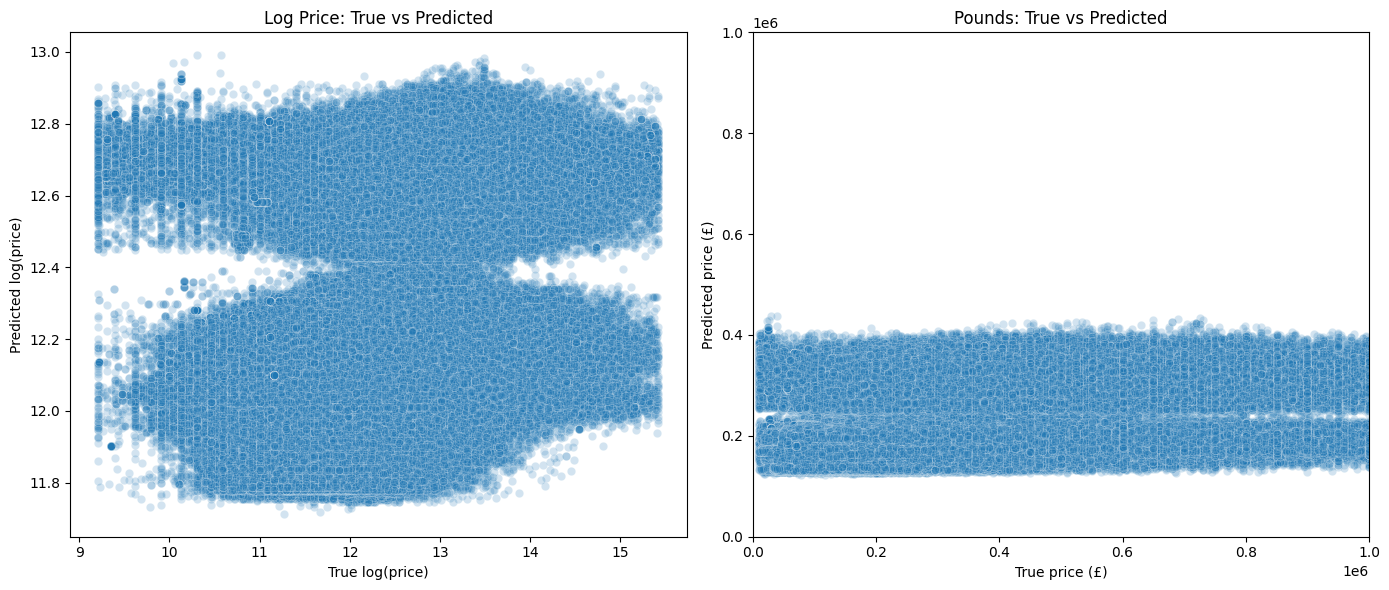

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.2)
plt.xlabel('True log(price)')
plt.ylabel('Predicted log(price)')
plt.title('Log Price: True vs Predicted')

plt.subplot(1,2,2)
sns.scatterplot(x=y_test_price, y=y_pred_price, alpha=0.2)
plt.xlabel('True price (£)')
plt.ylabel('Predicted price (£)')
plt.title('Pounds: True vs Predicted')
plt.xlim(0, 1_000_000)  # Limit top-end to aid visibility of majority
plt.ylim(0, 1_000_000)

plt.tight_layout()
plt.show()

## 9. Residual Plot
This code calculates residuals, which are the differences between the true and predicted log-transformed prices, then plots their distribution using a histogram with a kernel density estimate. The residuals represent errors in the model's predictions on the log scale, and this plot helps assess whether these errors are symmetrically distributed around zero, indicating unbiased predictions. A well-behaved residual distribution without strong skewness or outliers suggests the model fits the data reasonably and errors are randomly spread, which supports regression assumptions and model reliability.

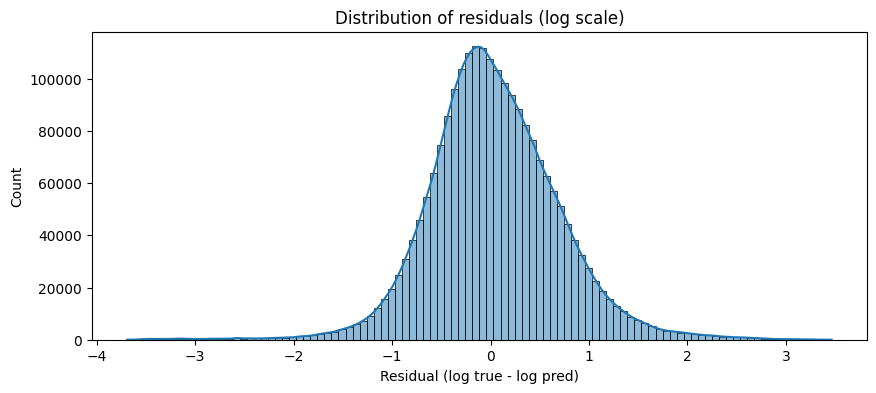

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10,4))
sns.histplot(residuals, bins=100, kde=True)
plt.xlabel('Residual (log true - log pred)')
plt.title('Distribution of residuals (log scale)')
plt.show()

## 10. Learning Curve Test
This code computes and plots the learning curves for the Ridge regression model by calculating the training and cross-validation root mean squared errors (RMSE) as the size of the training set increases. The plot visually shows how the model's performance improves with more training data, with the train RMSE representing fit and the cross-validation (CV) RMSE indicating generalization ability, helping diagnose whether the model suffers from bias or variance issues

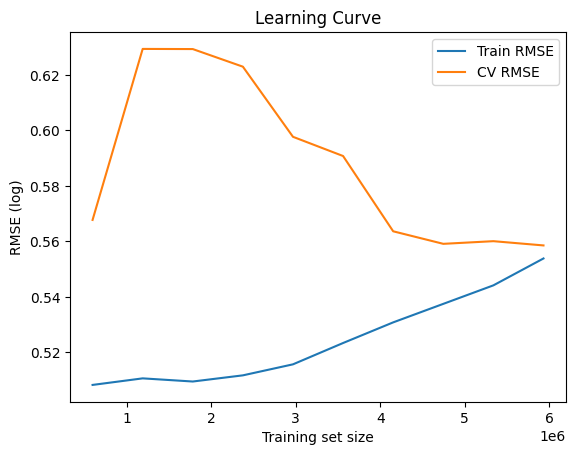

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error', cv=3
)
train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse = np.sqrt(-test_scores.mean(axis=1))

plt.plot(train_sizes, train_rmse, label='Train RMSE')
plt.plot(train_sizes, test_rmse, label='CV RMSE')
plt.xlabel('Training set size')
plt.ylabel('RMSE (log)')
plt.title('Learning Curve')
plt.legend()
plt.show()